In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import seaborn as sns
from pathlib import Path

In [76]:
path = Path().cwd()
dataPath = path / "data" / "HR_data.csv" #path.parent

data = pd.read_csv(dataPath)
set(data.dtypes)

data.sort_values(['Cohort', 'Round', 'Phase'], inplace=True)
data.reset_index(drop=True, inplace=True)

In [136]:
# Import Data
Data_results = copy.copy(data.iloc[:,1:52])
types = ['Round','Phase','Cohort','Individual','Puzzler']
Data_type = copy.copy(data[types])
Data_answers = copy.copy(data.iloc[:,54:].drop(columns=types[2:]))

# Convert to int
for t in types[:3]:
    # print(set(Data_type[t]))
    Data_type[t] = Data_type[t].str[-1].astype(int)
Data_type

# Fill NaNs
Data_results = Data_results.fillna(Data_results.mean())
Data_answers = Data_answers.fillna(Data_answers.median())


# for d in [Data_results,Data_type,Data_answers]:
#     print(np.sum(d.isnull().any(axis=0)))

# ['Frustrated', 'upset', 'hostile', 'alert', 'ashamed', 'inspired','nervous', 'attentive', 'afraid', 'active', 'determined']

# Flip negative columns
pos_list = ['inspired','attentive','active','determined']
ten_list = ['Frustrated']

new_columns = {}
for col in Data_answers:
    if col in ten_list:
        Data_answers[col] = Data_answers[col].values/2
    if col not in pos_list:
        print(f'{col} is flipped')
        new_columns[col] = col + '_flip'
        Data_answers[col] = 5-Data_answers[col]
Data_answers.rename(columns=new_columns, inplace=True)




# Normalize within Cohort
Normalize_group = True

def normalize_by_group(df, group_col, method='zscore'):
    df_normalized = df.copy()
    numeric_cols = df.select_dtypes(include='number').columns
    if method == 'zscore':
        func = lambda x: (x - x.mean()) / x.std()
    if method == 'submean':
        func = lambda x: (x - x.mean())
    elif method == 'minmax':
        func = lambda x: (x - x.min()) / (x.max() - x.min())
    else:
        raise ValueError("Unsupported method. Use 'zscore' or 'minmax'.")
    df_normalized[numeric_cols] = df.groupby(group_col)[numeric_cols].transform(func)
    return df_normalized

if Normalize_group:
    Data_results = normalize_by_group(Data_results,Data_type['Cohort'],method='submean')

# Data_results

# Combine them logically (no merge)
df = Data_results.copy()
df['Cohort'] = Data_type['Cohort']
df['Round'] = Data_type['Round']

Data_mean_results = pd.DataFrame()
for col in Data_results:
    # Group and transform
    Data_mean_results[f'mean_{col}'] = df.groupby(['Cohort', 'Round'])[col].transform('mean')


real_answers = Data_answers.columns
Data_answers['mean'] = Data_answers[real_answers].mean(axis=1)
Data_answers['min'] = Data_answers[real_answers].min(axis=1)
Data_answers['max'] = Data_answers[real_answers].max(axis=1)

# Data_answers


Frustrated is flipped
upset is flipped
hostile is flipped
alert is flipped
ashamed is flipped
nervous is flipped
afraid is flipped


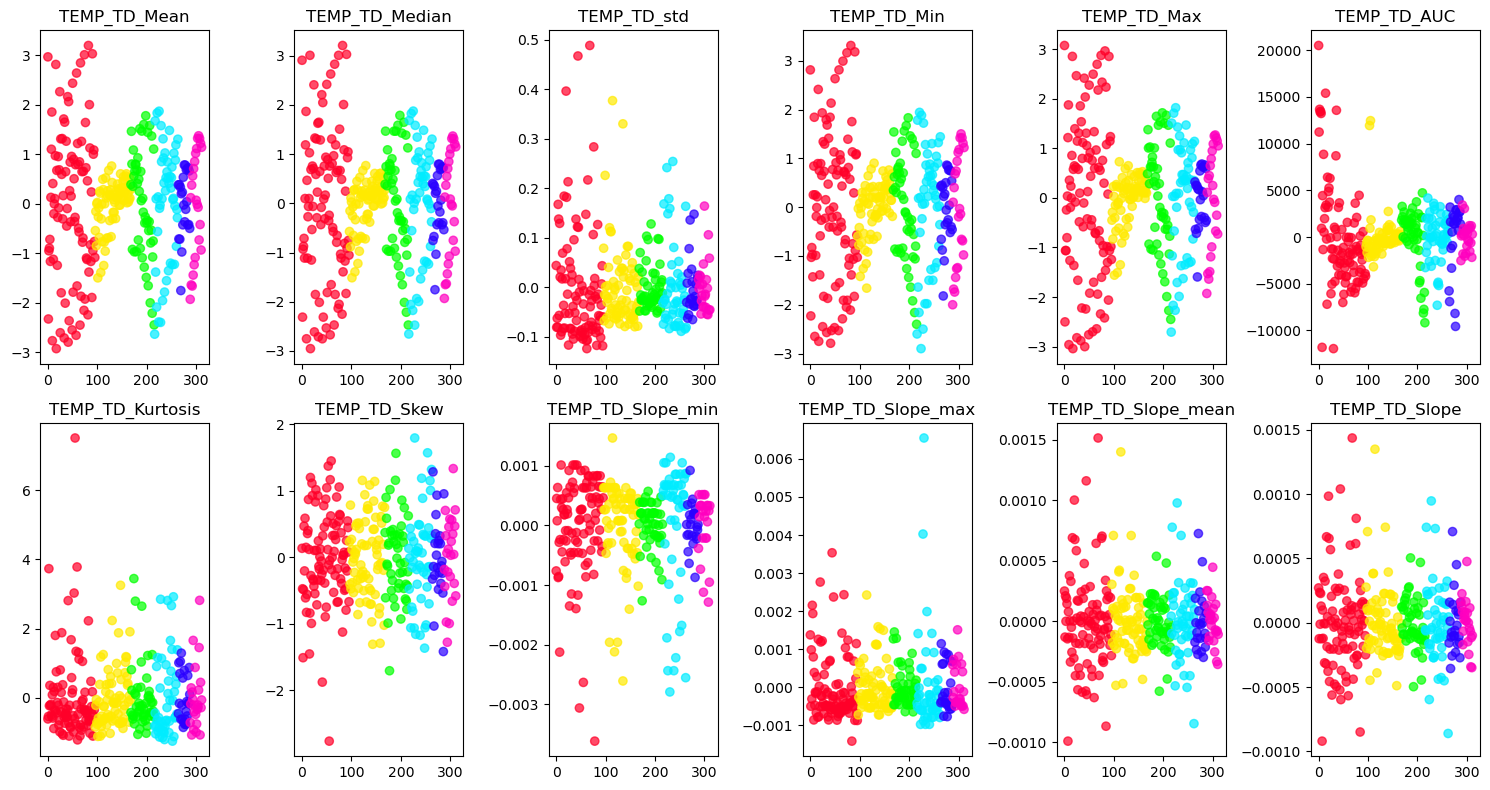

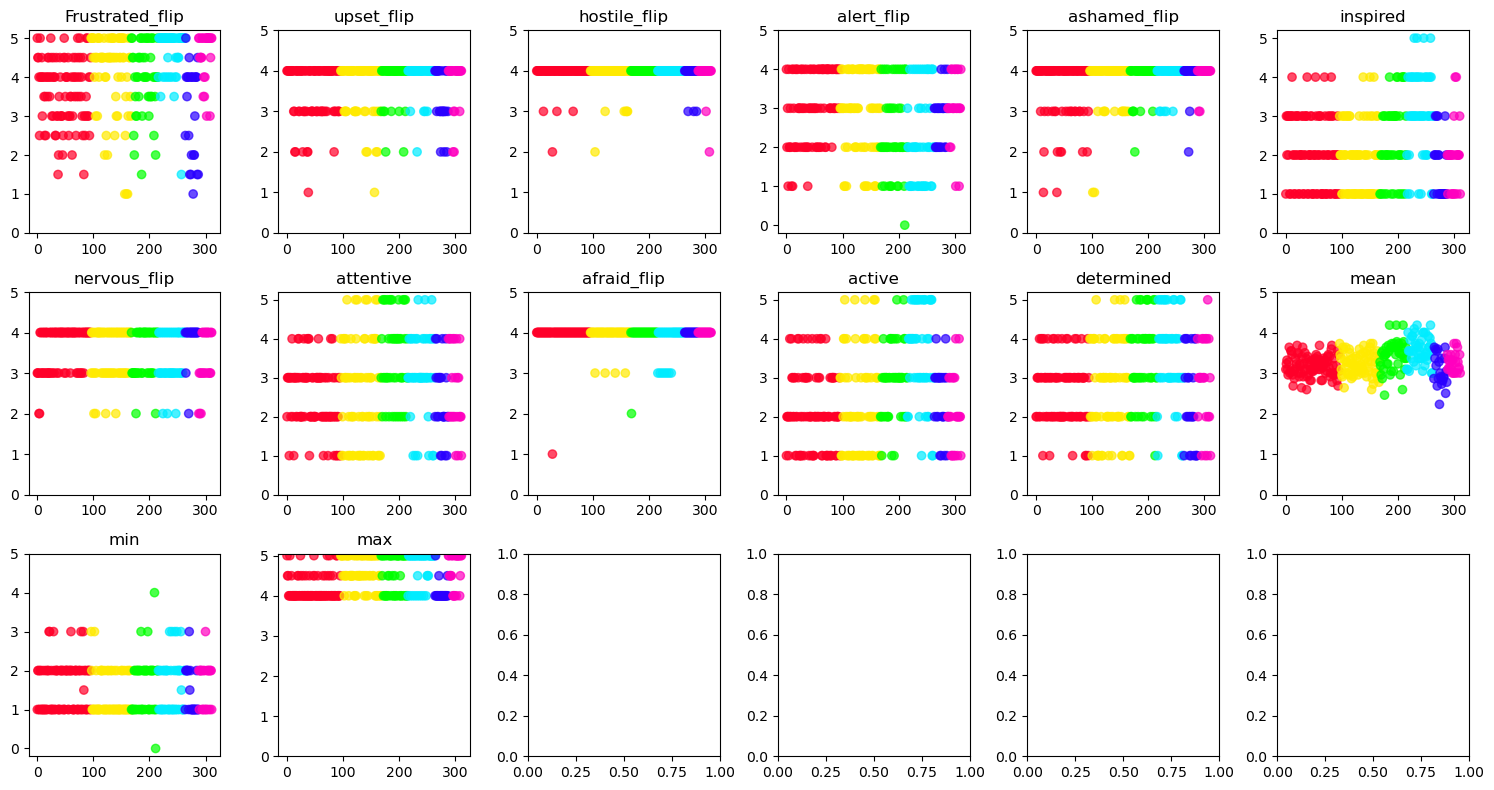

In [138]:
import math
def plotstuff(data,c=Data_type['Cohort'].values,fix=False):
    num_cols = 6
    fig, axes = plt.subplots(nrows= math.ceil(len(data.columns) / num_cols), ncols=num_cols, figsize=(15, 8)) 
    axes = axes.flatten()

    for i, col in enumerate(data.columns):
        ax = axes[i]
        
        scatter = ax.scatter(
            data.index, 
            data[col], 
            c = c,
            cmap='gist_rainbow',
            alpha=0.7
        )
        
        ax.set_title(col)
        if fix:
            ax.set_yticks(range(0, 6))

    plt.tight_layout()
    plt.show()

HR = range(0,12)
TEMP = range(12,24)
EDA_P = range(24,36)
EDA_T = range(36,48)
EDA_Rest = range(48,51)


'''plotstuff:
plot a dataframe colored by fx cohort or round
    example use:
--  plotstuff(Data_results.iloc[:,HR],c=Data_type['Cohort'])
->  plot data_results (HR colums) colored by cohort
'''

# plotstuff(Data_results.iloc[:,HR],c=Data_type['Round'])
plotstuff(Data_results.iloc[:,TEMP])
# plotstuff(Data_results.iloc[:,EDA_P])
# plotstuff(Data_results.iloc[:,EDA_T])
# plotstuff(Data_results.iloc[:,EDA_Rest])

# plotstuff(Data_mean_results.iloc[:,TEMP],c=Data_type['Cohort'].values)

plotstuff(Data_answers,fix=True)


In [54]:
from collections import Counter

Counter(Data_answers['Individual']);

In [ ]:
import plotly.express as px
import pandas as pd

In [95]:
Data_answers.iloc[:2]

,Individual,Puzzler,Frustrated,upset,hostile,alert,ashamed,inspired,nervous,attentive,afraid,active,determined
0,1,1,2.0,1.0,1.0,2.0,1.0,2.0,2.0,3.0,1.0,2.0,2.0
1,1,1,3.0,2.0,1.0,3.0,2.0,2.0,2.0,3.0,1.0,3.0,3.0


In [103]:
df = Data_answers.iloc[:]

df = df[df['Puzzler'] == 0]
df = df.iloc[:,2:]

# Build list of dimensions manually with forced ranges
dimensions = []
for col in df.columns:
    max_val = df[col].max()
    if max_val <= 5:  
        if col in ['inspired','attentive','active','determined']: 
            dimensions.append({'range': [5, 0],'label': col,'values': df[col]})
        else:
            dimensions.append({'range': [0, 5],'label': col,'values': df[col]})
    elif max_val <=10:
        dimensions.append({'range': [0, 10],'label': col,'values': df[col]})


# Create parallel coordinates plot
fig = px.parallel_coordinates(
    df,
    color="Frustrated",
    color_continuous_scale=px.colors.diverging.Tealrose
)

# Override the default dimensions with our forced ranges
fig.update_traces(dimensions=dimensions)
fig.show()
